## Simple QAT in JAX
Comparing QAT with PTQ in JAX

In [15]:
# @title 1. STE
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, random
from functools import partial

@jax.custom_vjp
def quantize(x, bits=4):
    q_max = 2**bits - 1
    # assuming x is pre-scaled to [0, 1] for this part
    return jnp.round(x * q_max) / q_max

def quantize_fwd(x, bits):
    return quantize(x, bits), None

def quantize_bwd(res, g):
    return g, None

quantize.defvjp(quantize_fwd, quantize_bwd)

In [16]:
# @title 2. Model and loss
def init_params(layers, key):
    keys = random.split(key, len(layers))
    return [(random.normal(k, (m, n)) * jnp.sqrt(2/m), jnp.zeros(n))
            for k, (m, n) in zip(keys, zip(layers[:-1], layers[1:]))]

def predict(params, x, do_qat=False, bits=4):
    for i, (w, b) in enumerate(params):
        if do_qat:
            # Scale to [-1, 1] then shift to [0, 1] for the quantizer
            scale = jnp.max(jnp.abs(w)) + 1e-8
            w_q = (quantize((w / scale + 1.0) / 2.0, bits) * 2.0 - 1.0) * scale
        else:
            w_q = w

        x = jnp.dot(x, w_q) + b
        if i < len(params) - 1: x = jax.nn.relu(x)
    return x

def loss_fn(params, x, y, do_qat):
    return jnp.mean((predict(params, x, do_qat) - y)**2)

@partial(jit, static_argnums=(4,))
def update(params, x, y, lr, do_qat):
    grads = grad(loss_fn)(params, x, y, do_qat)
    return [(w - lr * dw, b - lr * db) for (w, b), (dw, db) in zip(params, grads)]

In [19]:
# @title 3. Model training, PTQ and QAT
# 1. Setup
key = random.PRNGKey(42)
x_train = random.normal(key, (1000, 2))
y_train = jnp.sin(x_train[:, :1])

params_a = init_params([2, 64, 64, 1], key)
params_b = init_params([2, 64, 64, 1], key)

# 2. Training with LR Decay
# We start high to move fast, then drop to settle the quantized weights.
total_steps = 5000
initial_lr = 0.02

print("Training models...")
for i in range(total_steps):
    # Simple decay: drop LR by 10x after 75% of training
    current_lr = initial_lr if i < (total_steps * 0.75) else initial_lr * 0.1

    params_a = update(params_a, x_train, y_train, current_lr, False)
    params_b = update(params_b, x_train, y_train, current_lr, True)

# 3. PTQ: Rounding the FP32 model after it's fully trained
def apply_ptq(params, bits=4):
    p_out = []
    for w, b in params:
        s = jnp.max(jnp.abs(w)) + 1e-8
        wq = (quantize((w / s + 1.0) / 2.0, bits) * 2.0 - 1.0) * s
        p_out.append((wq, b))
    return p_out

params_ptq = apply_ptq(params_a)

# 4. Results
print("\n" + "="*30)
print(f"FP32 Baseline: {loss_fn(params_a, x_train, y_train, False):.6f}")
print(f"PTQ (4-bit):   {loss_fn(params_ptq, x_train, y_train, False):.6f} (Broken)")
print(f"QAT (4-bit):   {loss_fn(params_b, x_train, y_train, True):.6f} (Recovered!)")
print("="*30)

Training models...

FP32 Baseline: 0.004373
PTQ (4-bit):   0.043570 (Broken)
QAT (4-bit):   0.009921 (Recovered!)


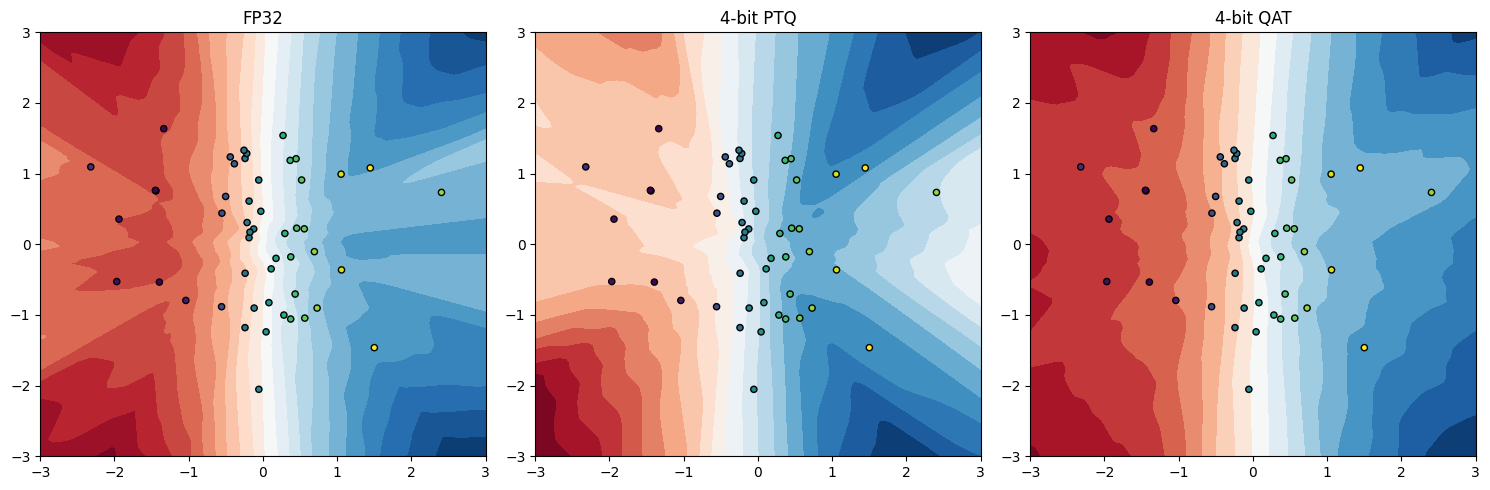

In [21]:
# @title 4. Visualization
import matplotlib.pyplot as plt

def plot_res(params, title, q_mode):
    res = 100
    x_range = jnp.linspace(-3, 3, res)
    xx, yy = jnp.meshgrid(x_range, x_range)
    grid = jnp.c_[xx.ravel(), yy.ravel()]

    preds = predict(params, grid, q_mode)

    plt.contourf(xx, yy, preds.reshape(xx.shape), levels=20, cmap='RdBu')
    plt.scatter(x_train[:50, 0], x_train[:50, 1], c=y_train[:50], edgecolors='k', s=20)
    plt.title(title)

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1); plot_res(params_a, "FP32", False)
plt.subplot(1,3,2); plot_res(params_ptq, "4-bit PTQ", False)
plt.subplot(1,3,3); plot_res(params_b, "4-bit QAT", True)
plt.tight_layout()
plt.show()